## csvのスクレイピング

In [53]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import os
import time

TARGET_URL = "https://www.mlit.go.jp/road/census/r3/index.html"

SAVE_DIR = "csv_data"
os.makedirs(SAVE_DIR, exist_ok=True)

headers = {
    "User-Agent": "Mozilla/5.0 (compatible; DataAnalysisStudent/1.0)"
}

res = requests.get(TARGET_URL, headers=headers)
res.raise_for_status()

soup = BeautifulSoup(res.text, "html.parser")

csv_links = []

for a in soup.find_all("a", href=True):
    href = a["href"]
    for i in range(1, 60):
        num = str(i).zfill(2)
        if href.lower().endswith(f"zkntrf{num}.csv"):
            # ⭐ ここが重要
            full_url = urljoin(TARGET_URL, href)
            csv_links.append(full_url)
print("取得したCSVリンク例:")
for link in csv_links[:5]:
    print(link)


取得したCSVリンク例:
https://www.mlit.go.jp/road/census/r3/data/csv/zkntrf01.csv
https://www.mlit.go.jp/road/census/r3/data/csv/zkntrf02.csv
https://www.mlit.go.jp/road/census/r3/data/csv/zkntrf03.csv
https://www.mlit.go.jp/road/census/r3/data/csv/zkntrf04.csv
https://www.mlit.go.jp/road/census/r3/data/csv/zkntrf05.csv


## csvのダウンロード

In [54]:
for i, url in enumerate(csv_links, start=1):
    filename = url.split("/")[-1]
    path = os.path.join(SAVE_DIR, filename)

    print(f"[{i}/{len(csv_links)}] ダウンロード中: {filename}")

    r = requests.get(url, headers=headers)

    # ⭐ 念のためステータス確認
    if r.status_code != 200:
        print(f"  スキップ（status={r.status_code}）: {url}")
        continue

    with open(path, "wb") as f:
        f.write(r.content)

    time.sleep(2)


[1/47] ダウンロード中: zkntrf01.csv
[2/47] ダウンロード中: zkntrf02.csv
[2/47] ダウンロード中: zkntrf02.csv
[3/47] ダウンロード中: zkntrf03.csv
[3/47] ダウンロード中: zkntrf03.csv
[4/47] ダウンロード中: zkntrf04.csv
[4/47] ダウンロード中: zkntrf04.csv
[5/47] ダウンロード中: zkntrf05.csv
[5/47] ダウンロード中: zkntrf05.csv
[6/47] ダウンロード中: zkntrf06.csv
[6/47] ダウンロード中: zkntrf06.csv
[7/47] ダウンロード中: zkntrf07.csv
[7/47] ダウンロード中: zkntrf07.csv
[8/47] ダウンロード中: zkntrf08.csv
[8/47] ダウンロード中: zkntrf08.csv
[9/47] ダウンロード中: zkntrf09.csv
[9/47] ダウンロード中: zkntrf09.csv
[10/47] ダウンロード中: zkntrf10.csv
[10/47] ダウンロード中: zkntrf10.csv
[11/47] ダウンロード中: zkntrf11.csv
[11/47] ダウンロード中: zkntrf11.csv
[12/47] ダウンロード中: zkntrf12.csv
[12/47] ダウンロード中: zkntrf12.csv
[13/47] ダウンロード中: zkntrf13.csv
[13/47] ダウンロード中: zkntrf13.csv
[14/47] ダウンロード中: zkntrf14.csv
[14/47] ダウンロード中: zkntrf14.csv
[15/47] ダウンロード中: zkntrf15.csv
[15/47] ダウンロード中: zkntrf15.csv
[16/47] ダウンロード中: zkntrf16.csv
[16/47] ダウンロード中: zkntrf16.csv
[17/47] ダウンロード中: zkntrf17.csv
[17/47] ダウンロード中: zkntrf17.csv
[18/47] ダウンロード中: zkntrf18.c

## csvの圧縮

In [ ]:
import os
import glob
import re
import pandas as pd

ZEN2HAN = str.maketrans("０１２３４５６７８９", "0123456789")

def read_csv_mlitsafe(path):
    try:
        return pd.read_csv(path, encoding="shift_jis")
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="cp932")


def compress_time_csv(
    src_dir="csv_data",
    out_dir="csv_compressed"
):
    os.makedirs(out_dir, exist_ok=True)

    csv_files = glob.glob(os.path.join(src_dir, "zkntrf*.csv"))

    for file in csv_files:
        df = read_csv_mlitsafe(file)

        pref_code = str(df.iloc[0]["都道府県指定市コード"])

        # 時間帯列（全角数字対応）
        time_cols = [c for c in df.columns if re.search(r"／[０-９]+時台", c)]
        if not time_cols:
            print("時間帯列なし:", file)
            continue

        # 数値化
        df[time_cols] = df[time_cols].apply(pd.to_numeric, errors="coerce")

        rows = []

        # 🔑 車種 × 上り下り で分けて集約
        for (vehicle, direction), g in df.groupby(["車種区分", "上り・下りの別"]):
            hour_sum = g[time_cols].sum()

            for col, volume in hour_sum.items():
                if pd.isna(volume):
                    continue

                hour = int(
                    re.search(r"／([０-９]+)時台", col)
                    .group(1)
                    .translate(ZEN2HAN)
                )

                rows.append([
                    pref_code,
                    hour,
                    vehicle,
                    direction,
                    int(volume)
                ])

        if not rows:
            print("出力行なし:", file)
            continue

        out_df = pd.DataFrame(
            rows,
            columns=[
                "pref_code",
                "hour",
                "vehicle_type",
                "direction",
                "traffic_volume"
            ]
        ).sort_values(["vehicle_type", "direction", "hour"])

        out_name = os.path.basename(file).replace(".csv", "_hour_by_type_dir.csv")
        out_path = os.path.join(out_dir, out_name)

        out_df.to_csv(out_path, index=False, encoding="utf-8")

        print(f"圧縮完了: {out_name}")


In [80]:
compress_time_csv()


圧縮完了: zkntrf07_hour_by_type_dir.csv
圧縮完了: zkntrf13_hour_by_type_dir.csv
圧縮完了: zkntrf12_hour_by_type_dir.csv
圧縮完了: zkntrf06_hour_by_type_dir.csv
圧縮完了: zkntrf10_hour_by_type_dir.csv
圧縮完了: zkntrf04_hour_by_type_dir.csv
圧縮完了: zkntrf38_hour_by_type_dir.csv
圧縮完了: zkntrf39_hour_by_type_dir.csv
圧縮完了: zkntrf05_hour_by_type_dir.csv
圧縮完了: zkntrf11_hour_by_type_dir.csv
圧縮完了: zkntrf29_hour_by_type_dir.csv
圧縮完了: zkntrf15_hour_by_type_dir.csv
圧縮完了: zkntrf01_hour_by_type_dir.csv
圧縮完了: zkntrf14_hour_by_type_dir.csv
圧縮完了: zkntrf05_hour_by_type_dir.csv
圧縮完了: zkntrf11_hour_by_type_dir.csv
圧縮完了: zkntrf29_hour_by_type_dir.csv
圧縮完了: zkntrf15_hour_by_type_dir.csv
圧縮完了: zkntrf01_hour_by_type_dir.csv
圧縮完了: zkntrf14_hour_by_type_dir.csv
圧縮完了: zkntrf28_hour_by_type_dir.csv
圧縮完了: zkntrf02_hour_by_type_dir.csv
圧縮完了: zkntrf16_hour_by_type_dir.csv
圧縮完了: zkntrf17_hour_by_type_dir.csv
圧縮完了: zkntrf03_hour_by_type_dir.csv
圧縮完了: zkntrf45_hour_by_type_dir.csv
圧縮完了: zkntrf44_hour_by_type_dir.csv
圧縮完了: zkntrf46_hour_by_type_

## dbに挿入

In [4]:
import glob
import pandas as pd
import sqlite3
import os

def insert_csv_to_db(
    csv_dir="csv_compressed",
    db_path="traffic.db"
):
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()

    csv_files = glob.glob(os.path.join(csv_dir, "*.csv"))

    for file in csv_files:
        df = pd.read_csv(file, encoding="utf-8")

        records = df[
            ["pref_code", "hour", "vehicle_type", "direction", "traffic_volume"]
        ].values.tolist()

        cur.executemany(
            """
            INSERT INTO traffic_by_hour
            VALUES (?, ?, ?, ?, ?)
            """,
            records
        )

        print("DB挿入:", os.path.basename(file), "行数:", len(records))

    conn.commit()
    conn.close()

insert_csv_to_db()

DB挿入: zkntrf29_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf11_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf14_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf23_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf26_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf34_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf09_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf31_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf47_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf06_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf42_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf03_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf22_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf27_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf10_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf28_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf15_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf07_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf46_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf02_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf43_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf35_hour_by_type_dir.csv 行数: 96
DB挿入: zkntrf30_hour_by_type_dir.csv 行数: 96
DB挿入: zkntr

In [5]:
conn = sqlite3.connect("traffic.db")


## 時間帯別の交通量のグラフ

/Users/komazaki/ds_pro/dsprog2_2025/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/komazaki/ds_pro/dsprog2_2025/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/komazaki/ds_pro/dsprog2_2025/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/komazaki/ds_pro/dsprog2_2025/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/komazaki/ds_pro/dsprog2_2025/.venv/lib/python

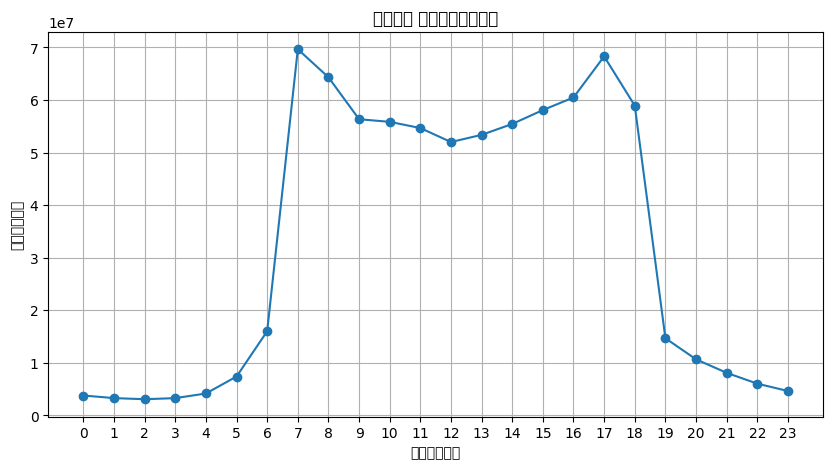

In [6]:
import matplotlib.pyplot as plt

df = pd.read_sql_query("""
    SELECT hour, SUM(traffic_volume) AS total_volume
    FROM traffic_by_hour
    GROUP BY hour
    ORDER BY hour
""", conn)

plt.figure(figsize=(10, 5))
plt.plot(df["hour"], df["total_volume"], marker="o")
plt.xlabel("時間帯（時）")
plt.ylabel("交通量（台）")
plt.title("時間帯別 総交通量（全国）")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


## 上り下り別の交通量のグラフ

/Users/komazaki/ds_pro/dsprog2_2025/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/komazaki/ds_pro/dsprog2_2025/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/komazaki/ds_pro/dsprog2_2025/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/komazaki/ds_pro/dsprog2_2025/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/komazaki/ds_pro/dsprog2_2025/.venv/lib/python

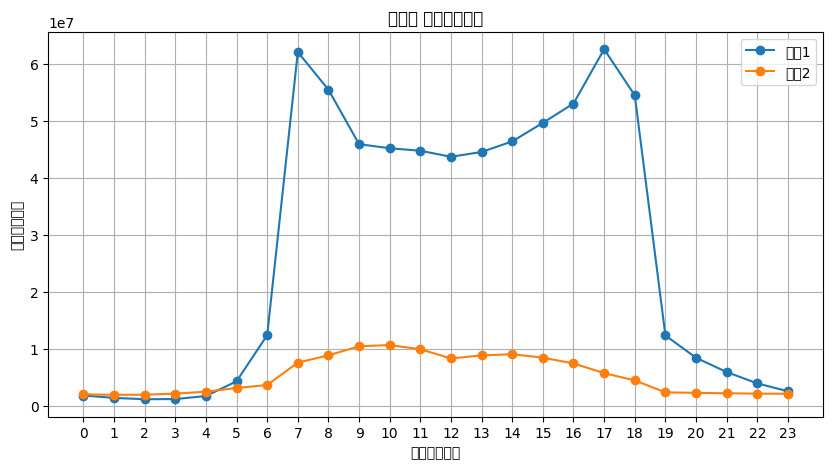

In [13]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect("traffic.db")

df = pd.read_sql_query("""
    SELECT hour, vehicle_type, SUM(traffic_volume) AS total_volume
    FROM traffic_by_hour
    WHERE vehicle_type IN (1, 2, 9)
    GROUP BY hour, vehicle_type
    ORDER BY hour
""", conn)

conn.close()

# コード→名前変換
VEHICLE_MAP = {
    1: "普通車",
    2: "大型車",
    9: "自動車類計"
}

plt.figure(figsize=(10,5))

for v in df["vehicle_type"].unique():

    d = df[df["vehicle_type"] == v]

    label = VEHICLE_MAP.get(v, f"種別{v}")

    plt.plot(
        d["hour"],
        d["total_volume"],
        marker="o",
        label=label
    )

plt.xlabel("時間帯（時）")
plt.ylabel("交通量（台）")
plt.title("車種別 時間帯交通量")
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()


## 地域別の交通量の違いのグラフ

findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Fon

データ読み込み中...
地域別集計中...
グラフ描画中...


findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Fon

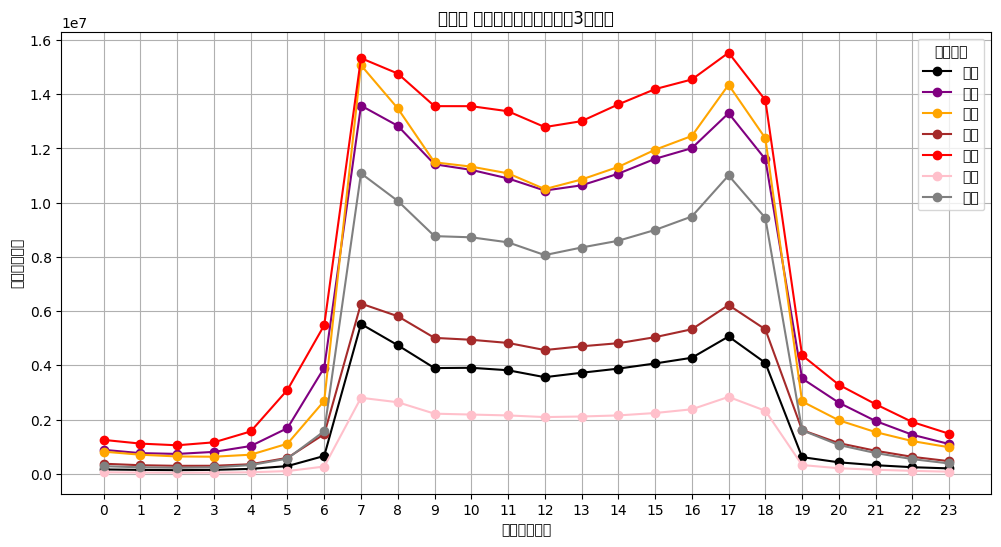

完了！


In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm




# ============================
# 日本語フォント設定（文字化け対策）
# ============================

# Mac / Windows 両対応しやすい設定
plt.rcParams["font.family"] = "IPAexGothic"  # もし無ければ後述参照
plt.rcParams["axes.unicode_minus"] = False


# ============================
# 都道府県コード → 地域変換
# ============================

def pref_to_region(pref_code):

    code = int(str(pref_code)[:2])

    if code == 1:
        return "北海道"
    elif 2 <= code <= 7:
        return "東北"
    elif 8 <= code <= 14:
        return "関東"
    elif 15 <= code <= 23:
        return "中部"
    elif 24 <= code <= 30:
        return "近畿"
    elif 31 <= code <= 35:
        return "中国"
    elif 36 <= code <= 39:
        return "四国"
    elif 40 <= code <= 47:
        return "九州"
    else:
        return "不明"


# ============================
# DB読み込み
# ============================

def load_data(db_path="traffic.db"):

    conn = sqlite3.connect(db_path)

    df = pd.read_sql_query("""
        SELECT pref_code, hour, traffic_volume
        FROM traffic_by_hour
    """, conn)

    conn.close()

    return df


# ============================
# 地域別集計
# ============================

def aggregate_by_region(df):

    df["region"] = df["pref_code"].apply(pref_to_region)

    df_region = (
        df
        .groupby(["region", "hour"])["traffic_volume"]
        .sum()
        .reset_index()
        .sort_values("hour")
    )

    return df_region


# ============================
# グラフ描画（色指定付き）
# ============================

def plot_region_traffic(df_region):

    # 地域ごとの色を固定（見やすさUP）
    REGION_COLOR = {
        "北海道": "blue",
        "東北": "green",
        "関東": "red",
        "中部": "orange",
        "近畿": "purple",
        "中国": "brown",
        "四国": "pink",
        "九州": "gray",
        "不明": "black"
    }

    plt.figure(figsize=(12, 6))

    for region in df_region["region"].unique():

        d = df_region[df_region["region"] == region]

        color = REGION_COLOR.get(region, "black")

        plt.plot(
            d["hour"],
            d["traffic_volume"],
            marker="o",
            color=color,
            label=region
        )

    plt.xlabel("時間帯（時）")
    plt.ylabel("交通量（台）")
    plt.title("地域別 時間帯別交通量（令和3年度）")

    plt.xticks(range(24))
    plt.legend(title="地方区分")
    plt.grid(True)

    plt.show()


# ============================
# メイン処理
# ============================

def main():

    print("データ読み込み中...")
    df = load_data()

    print("地域別集計中...")
    df_region = aggregate_by_region(df)

    print("グラフ描画中...")
    plot_region_traffic(df_region)

    print("完了！")


# 実行
main()


In [18]:
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.plot([1,2,3],[4,5,6])
plt.title("日本語テスト：交通量")
plt.xlabel("時間")
plt.ylabel("台数")
plt.show()


ModuleNotFoundError: No module named 'japanize_matplotlib'